In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
data = pd.read_csv(
    "customer_segmentation_project.zip", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [4]:
data['InvoiceDate'] = data['InvoiceDate'].astype('datetime64[ns]')
data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [5]:
print(f"Минимальное кол-во заказов: {data['UnitPrice'].describe().loc['min']}")

Минимальное кол-во заказов: -11062.06


In [6]:
print(f"Минимальное кол-во заказов: {data['Quantity'].describe().loc['min']}")
print(f"Максимальное кол-во заказов: {data['Quantity'].describe().loc['max']}")
print(f"Уникальных клиентов: {data['CustomerID'].describe().loc['unique']}")
print(f"Уникальных стран: {data['Country'].describe().loc['unique'] - 1}")
print(f"Самый популярные товар: {data['StockCode'].describe().loc['top']}")
print(f"Всего пропусков в данных: {data.isna().sum().sum()}")
print(f"Строк до удаления пропусков: {data.shape[0]}")
data = data.dropna(axis=0)
print(f"Строк после удаления пропусков: {data.shape[0]}")
print(f"Строк до удаления дублей: {data.shape[0]}")
data = data.drop_duplicates()
print(f"Строк после удаления дублей: {data.shape[0]}")

Минимальное кол-во заказов: -80995.0
Максимальное кол-во заказов: 80995.0
Уникальных клиентов: 4372
Уникальных стран: 37
Самый популярные товар: 85123A
Всего пропусков в данных: 136534
Строк до удаления пропусков: 541909
Строк после удаления пропусков: 406829
Строк до удаления дублей: 406829
Строк после удаления дублей: 401604


In [8]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


In [9]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
...,...,...,...
22185,18283,579673,50
22186,18283,580872,50
22187,18287,554065,29
22188,18287,570715,38


In [10]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)
round(nb_products_per_basket['order_canceled'].value_counts()[1] / nb_products_per_basket.shape[0] *100)

16

In [11]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


In [13]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


In [15]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1]

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1
...,...,...,...,...
22159,18274,C577832,11,1
22161,18276,C577386,1,1
22162,18276,C577390,1,1
22164,18277,C542086,1,1


In [17]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1].shape[0] == data[data['Quantity'] < 0].shape[0]

False

In [19]:
data[data['InvoiceNo'].str.contains('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [20]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

In [21]:
data['QuantityCanceled'] = quantity_canceled
data = data[data['Quantity'] > 0]
data = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True) == False]
data = data[data['UnitPrice'] != 0]
data.shape

(391150, 9)

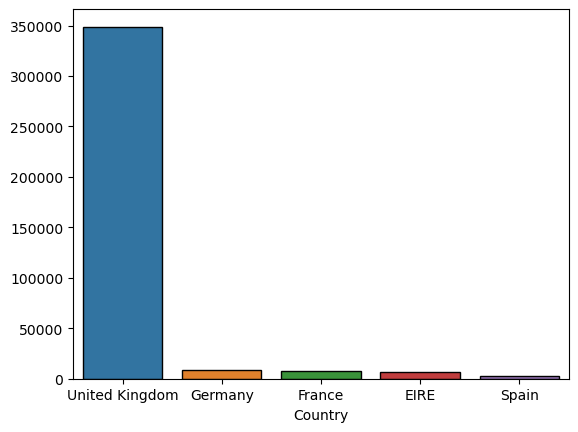

In [22]:
# Топ-5 стран по количеству заказов
plot_df = data.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
sns.barplot(x=plot_df[:5].index, y=plot_df[:5].values);

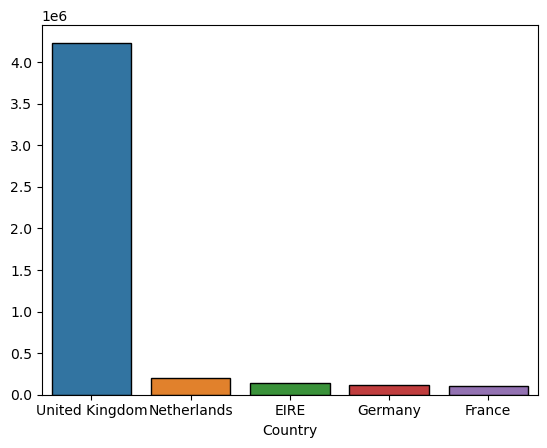

In [23]:
# Топ-5 стран по количеству товаров
plot_df = data.groupby('Country')['Quantity'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df[:5].index, y=plot_df[:5].values);

In [24]:
#общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])
print(f"Средняя общая стоимость заказа: {round(data['TotalPrice'].mean())} £")

Средняя общая стоимость заказа: 21 £


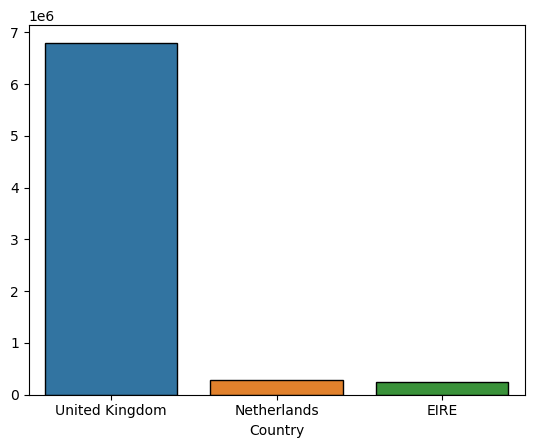

In [25]:
# Топ-3 страны по выручке
plot_df = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df[:3].index, y=plot_df[:3].values);

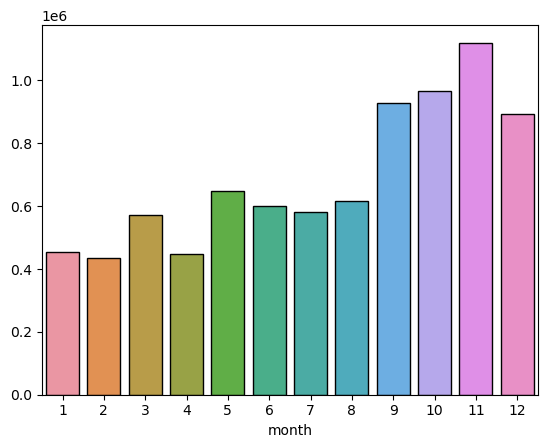

In [27]:
data['month'] = data['InvoiceDate'].dt.month
data['day_of_week'] = data['InvoiceDate'].dt.day_of_week
data['hour'] = data['InvoiceDate'].dt.hour
plot_df = data.groupby('month')['TotalPrice'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df.index, y=plot_df.values);

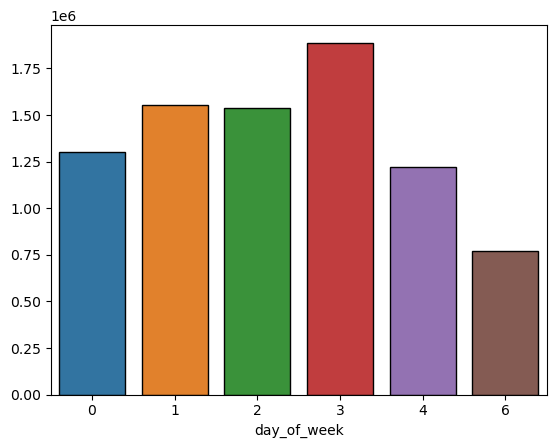

In [28]:
plot_df = data.groupby('day_of_week')['TotalPrice'].sum().sort_values(ascending=False)
sns.barplot(x=plot_df.index, y=plot_df.values);

<Axes: xlabel='hour', ylabel='date'>

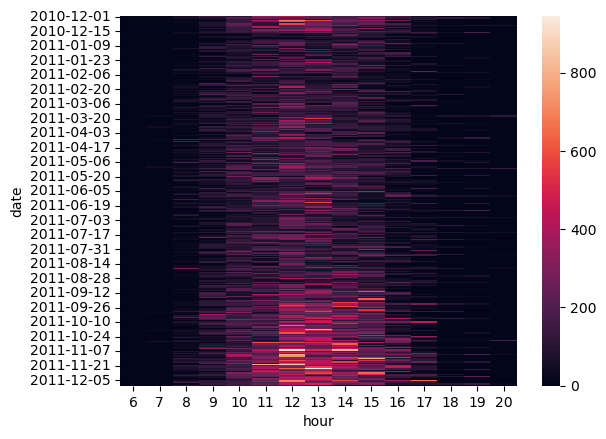

In [29]:
# HeatMap по датам и часам заказов (посчитаем количества заказанных товаров)
data['date'] = data['InvoiceDate'].dt.date
plot_df = data.pivot_table(
    values='Quantity',
    index='date',
    columns='hour',
    aggfunc='count',
    fill_value=0)

sns.heatmap(plot_df)

In [30]:
recency_data = data.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_data['Recency'] = pd.to_datetime('2011-12-10') - recency_data['InvoiceDate']
recency_data['Recency'] = recency_data['Recency'].dt.days
rfm_table = pd.DataFrame({
    'Recently':recency_data['Recency'].values,
    'Frequency':data.groupby('CustomerID')['InvoiceNo'].nunique(),
    'Monetary':data.groupby('CustomerID')['TotalPrice'].sum()
})

print(f"Клиенты совершившие заказ более 200 дней назад: {rfm_table[rfm_table['Recently'] > 200].shape[0]}")
print(f"Среднее количество заказов в год: {round(rfm_table['Frequency'].mean())}")
print(f"Сумма покупок клиента №12360: {round(rfm_table.loc['12360'][2])}")

Клиенты совершившие заказ более 200 дней назад: 743
Среднее количество заказов в год: 4
Сумма покупок клиента №12360: 2302


In [31]:
f_bound = np.quantile(rfm_table['Frequency'], 0.95)
m_bound = np.quantile(rfm_table['Monetary'], 0.95)
rfm_table_cleaned = rfm_table[~((rfm_table['Frequency'] > f_bound) | (rfm_table['Monetary'] > m_bound))]
print(rfm_table_cleaned.shape[0])

4044


Доля дисперсий объяснённая первой компонентой: 0.68


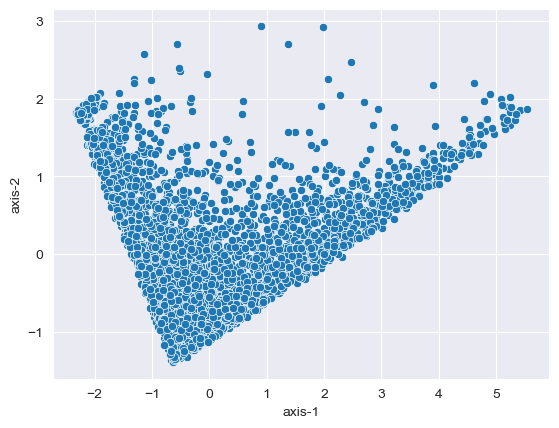

In [68]:
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=2)
pipe = pipeline.Pipeline(steps=[('scaler', scaler), ('pca', pca)])
rfm_table_processed = pipe.fit_transform(rfm_table_cleaned)

print(f"Доля дисперсий объяснённая первой компонентой: {round(pipe['pca'].explained_variance_ratio_[0], 2)}")

rfm_table_processed = pd.DataFrame(rfm_table_processed, columns = ['axis-1', 'axis-2'])

sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

<Axes: xlabel='clusters', ylabel='inertia'>

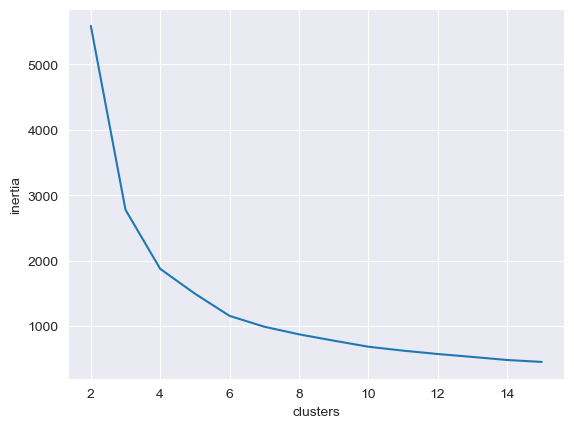

In [40]:
# k-mean - метод локтя
def get_result(clust_num, data):
    k_means = cluster.KMeans(n_clusters=clust_num, random_state=42)
    k_means.fit(data)
    return k_means.inertia_

results = {'inertia':[], 'clusters':[]}

for clust_num in range(2, 16):
    results['inertia'].append(get_result(clust_num, rfm_table_processed))
    results['clusters'].append(clust_num)
    
plot_df = pd.DataFrame(results)

sns.set_style("darkgrid")
sns.lineplot(x=plot_df['clusters'], y=plot_df['inertia']);

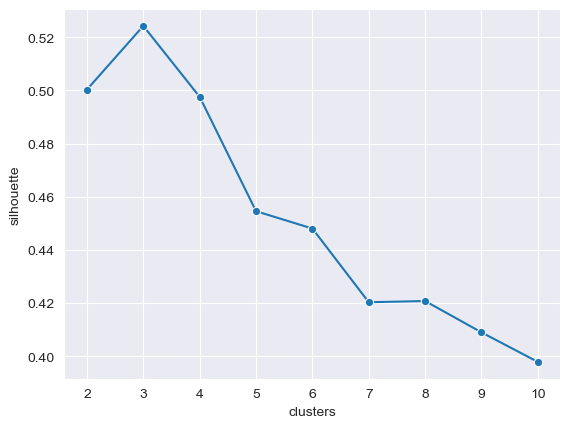

In [47]:
# k-mean - коэффициент силуэта

def get_silhouette(clust_num, data):
    k_means = cluster.KMeans(n_clusters=clust_num, random_state=42)
    k_means.fit(data)
    silhouette = metrics.silhouette_score(data, k_means.predict(data))
    return silhouette

results = {'silhouette':[], 'clusters':[]}

for clust_num in range(2, 11):
    results['silhouette'].append(get_silhouette(clust_num, rfm_table_processed))
    results['clusters'].append(clust_num)
    
plot_df = pd.DataFrame(results)

sns.set_style("darkgrid")
sns.lineplot(x=plot_df['clusters'], y=plot_df['silhouette'], marker='o');

print(f"Максимальное значение коэф. силуета: {round(max(results['silhouette']),2)}")

Максимальное значение коэф. силуета: 0.44


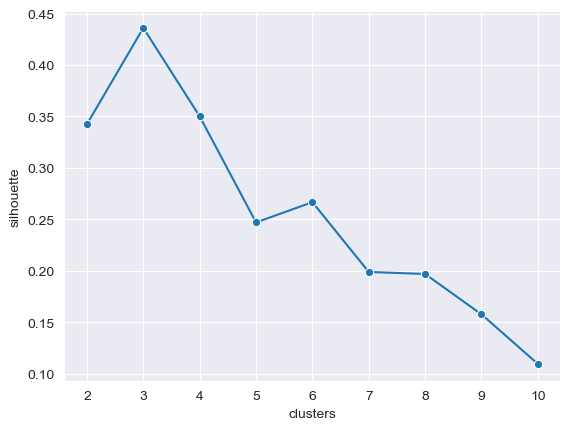

In [49]:
# GaussianMixture - коэффициент силуэта

def get_silhouette(clust_num, data):
    gm_clustering = mixture.GaussianMixture(n_components=clust_num, random_state=42)
    gm_clustering.fit(data)
    silhouette = metrics.silhouette_score(data, gm_clustering.predict(data))
    return silhouette

results = {'silhouette':[], 'clusters':[]}

for clust_num in range(2, 11):
    results['silhouette'].append(get_silhouette(clust_num, rfm_table_processed))
    results['clusters'].append(clust_num)
    
plot_df = pd.DataFrame(results)

sns.set_style("darkgrid")
sns.lineplot(x=plot_df['clusters'], y=plot_df['silhouette'], marker='o');

print(f"Максимальное значение коэф. силуета: {round(max(results['silhouette']),2)}")

2    2269
1     999
0     776
Name: Label, dtype: int64


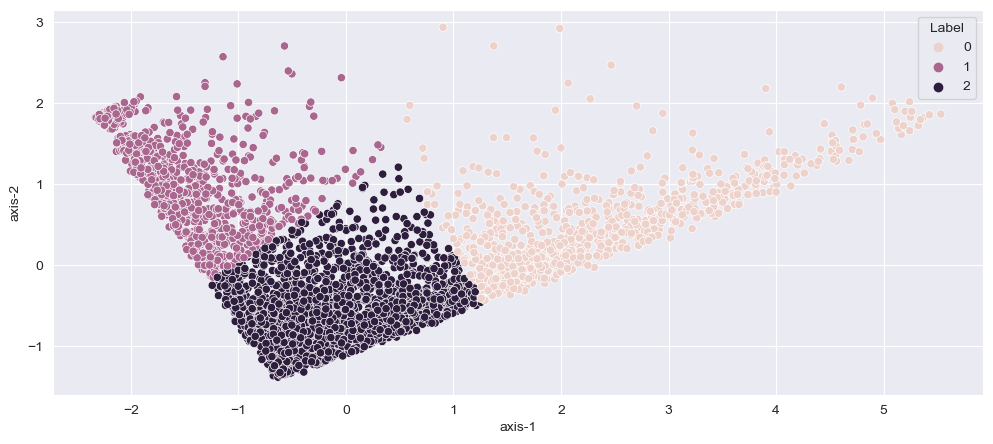

In [70]:
k_means = cluster.KMeans(n_clusters=3, random_state=42)
k_means.fit(rfm_table_processed)

rfm_table_processed.loc[:, 'Label'] = k_means.labels_
print(rfm_table_processed['Label'].value_counts())

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue='Label'
);

In [71]:
rfm_table_cleaned['Label'] = rfm_table_processed['Label'].values
rfm_table_cleaned_group = rfm_table_cleaned.groupby('Label').mean()
print(f"Максимальное среднее значение Frequency: {round(rfm_table_cleaned_group['Frequency'].max())}")

Максимальное среднее значение Frequency: 7


In [74]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    
plot_cluster_profile(rfm_table_cleaned_group, 3)

In [75]:
rfm_table_cleaned.drop('Label', axis=1, inplace=True)
scaler = preprocessing.StandardScaler()
t_sne = manifold.TSNE(n_components=2, perplexity=50, random_state=100)
pipe = pipeline.Pipeline(steps=[('scaler', scaler), ('t_sne', t_sne)])
rfm_table_processed = pipe.fit_transform(rfm_table_cleaned)
print(f"Значение дивергенции Кульбака — Лейблера: {round(pipe[1].kl_divergence_, 2)}")
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'])

Значение дивергенции Кульбака — Лейблера: 0.54


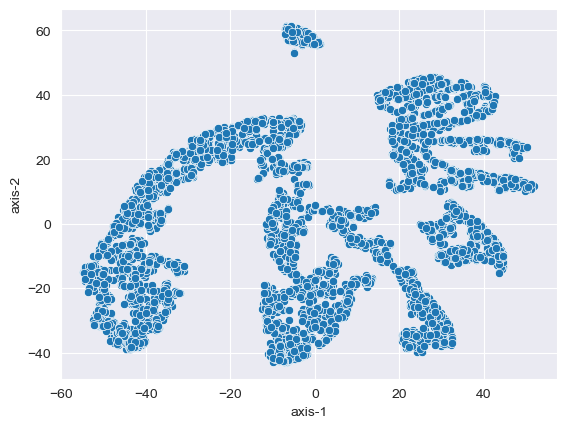

In [82]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Максимальное значение коэф. силуета: 0.47999998927116394


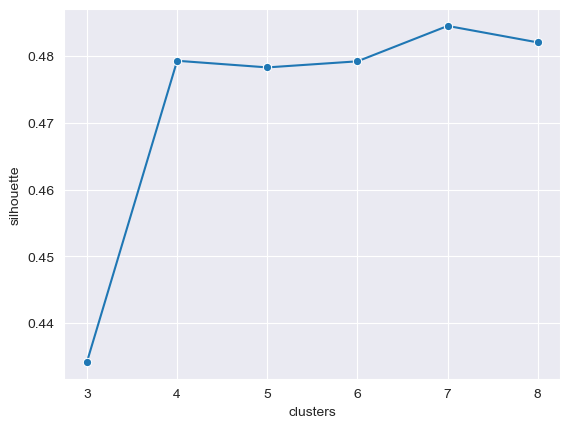

In [81]:
# k-mean - коэффициент силуэта
def get_silhouette(clust_num, data):
    k_means = cluster.KMeans(n_clusters=clust_num, random_state=42)
    k_means.fit(data)
    silhouette = metrics.silhouette_score(data, k_means.predict(data))
    return silhouette

results = {'silhouette':[], 'clusters':[]}

for clust_num in range(3, 9):
    results['silhouette'].append(get_silhouette(clust_num, rfm_table_processed))
    results['clusters'].append(clust_num)
    
plot_df = pd.DataFrame(results)

sns.set_style("darkgrid")
sns.lineplot(x=plot_df['clusters'], y=plot_df['silhouette'], marker='o');

print(f"Максимальное значение коэф. силуета: {round(max(results['silhouette']), 2)}")

Максимальное значение коэф. силуета: 0.4699999988079071


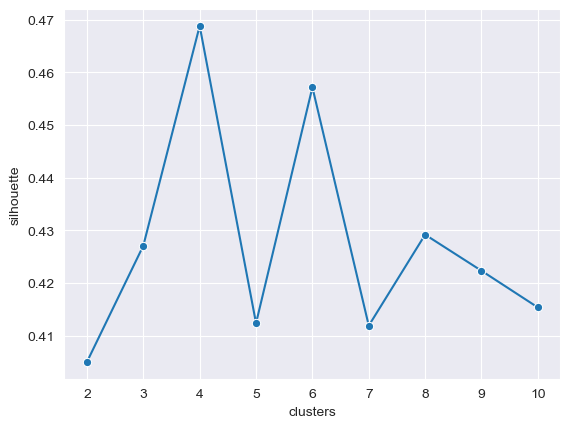

In [83]:
# GaussianMixture - коэффициент силуэта

def get_silhouette(clust_num, data):
    gm_clustering = mixture.GaussianMixture(n_components=clust_num, random_state=42)
    gm_clustering.fit(data)
    silhouette = metrics.silhouette_score(data, gm_clustering.predict(data))
    return silhouette

results = {'silhouette':[], 'clusters':[]}

for clust_num in range(2, 11):
    results['silhouette'].append(get_silhouette(clust_num, rfm_table_processed))
    results['clusters'].append(clust_num)
    
plot_df = pd.DataFrame(results)

sns.set_style("darkgrid")
sns.lineplot(x=plot_df['clusters'], y=plot_df['silhouette'], marker='o');

print(f"Максимальное значение коэф. силуета: {round(max(results['silhouette']),2)}")

Максимальное значение коэф. силуета: 0.47999998927116394


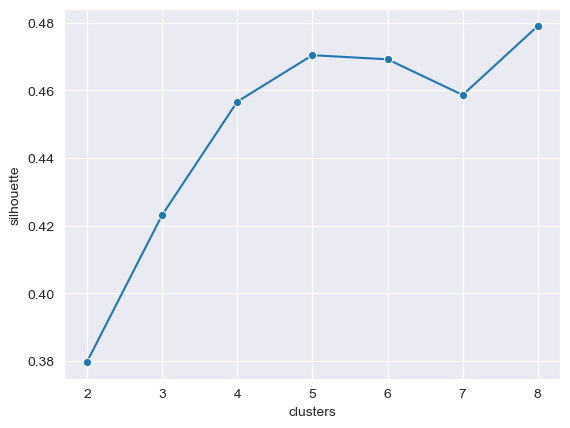

In [88]:
# AgglomerativeClustering - коэффициент силуэта

def get_silhouette(clust_num, data):
    agg_clustering = cluster.AgglomerativeClustering(n_clusters=clust_num)
    agg_clustering.fit(data)
    silhouette = metrics.silhouette_score(data, agg_clustering.labels_)
    return silhouette

results = {'silhouette':[], 'clusters':[]}

for clust_num in range(2, 9):
    results['silhouette'].append(get_silhouette(clust_num, rfm_table_processed))
    results['clusters'].append(clust_num)
    
plot_df = pd.DataFrame(results)

sns.set_style("darkgrid")
sns.lineplot(x=plot_df['clusters'], y=plot_df['silhouette'], marker='o');

print(f"Максимальное значение коэф. силуета: {round(max(results['silhouette']),2)}")

In [92]:
k_means = cluster.KMeans(n_clusters=7, random_state=42)
k_means.fit(rfm_table_processed)
rfm_table_processed['label'] = k_means.labels_
rfm_table_processed['label'].value_counts()

2    914
4    678
5    655
6    548
0    446
1    406
3    397
Name: label, dtype: int64

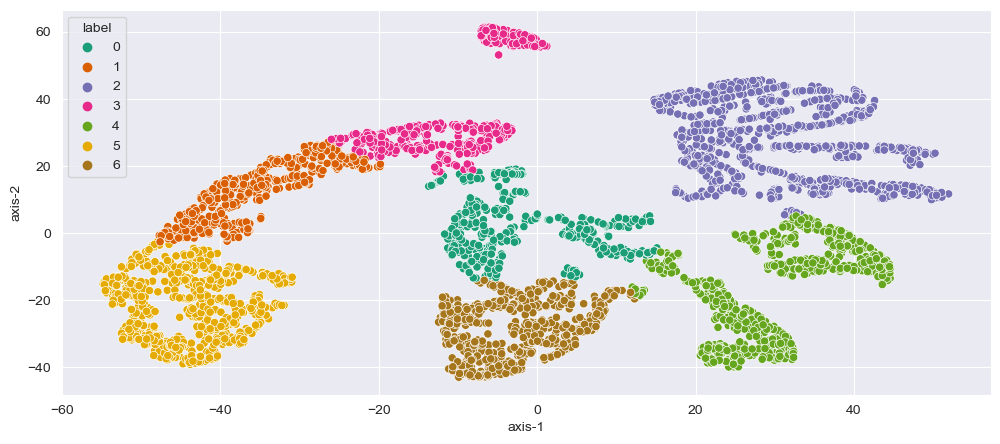

In [104]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue='label',
    palette='Dark2'
);

In [108]:
rfm_table_cleaned['label'] = rfm_table_processed['label'].values
rfm_table_cleaned_group = rfm_table_cleaned.groupby('label').mean()
print(f"Максимальное среднее значение Recency: {round(rfm_table_cleaned_group['Recently'].max())}")

Максимальное среднее значение Recency: 313


In [109]:
X = rfm_table_cleaned.drop('label', axis=1)
y = rfm_table_cleaned['label']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

grid_search = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)
print(f"Best params: {grid_search.best_params_}")
print(f"Accuracy score:{round(metrics.accuracy_score(y_test, y_pred), 3)}")

Best params: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
Accuracy score:0.985


In [111]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

grid_gbm = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

grid_gbm.fit(X_train, y_train)
y_pred_gbm = grid_gbm.predict(X_test)
print(f"Best params: {grid_gbm.best_params_}")
print(f"Accuracy score:{round(metrics.accuracy_score(y_test, y_pred_gbm), 3)}")

Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Accuracy score:0.989
